<a href="https://colab.research.google.com/github/proteenteen/AI_FinalProject/blob/main/LeVanManhQuynh_20146147.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [1]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-7-e6246fad2a96>:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 20)           2400      
                                                                 
 conv1d (Conv1D)             (None, 120, 128)          10368     
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 64)           32832     
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                        

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
27/27 [==============================] - 2s 26ms/step - loss: 2.8327 - accuracy: 0.0606
Epoch 2/200
27/27 [==============================] - 1s 24ms/step - loss: 2.8289 - accuracy: 0.0758
Epoch 3/200
27/27 [==============================] - 1s 22ms/step - loss: 2.8296 - accuracy: 0.0455
Epoch 4/200
27/27 [==============================] - 1s 20ms/step - loss: 2.8280 - accuracy: 0.0909
Epoch 5/200
27/27 [==============================] - 1s 20ms/step - loss: 2.8246 - accuracy: 0.0758
Epoch 6/200
27/27 [==============================] - 1s 21ms/step - loss: 2.8207 - accuracy: 0.0606
Epoch 7/200
27/27 [==============================] - 1s 21ms/step - loss: 2.8135 - accuracy: 0.0758
Epoch 8/200
27/27 [==============================] - 1s 25ms/step - loss: 2.8214 - accuracy: 0.0530
Epoch 9/200
27/27 [==============================] - 1s 30ms/step - loss: 2.8236 - accuracy: 0.0303
Epoch 10/200
27/27 [==============================] - 1s 30ms/step - loss: 2.8148 - accuracy: 0.0530

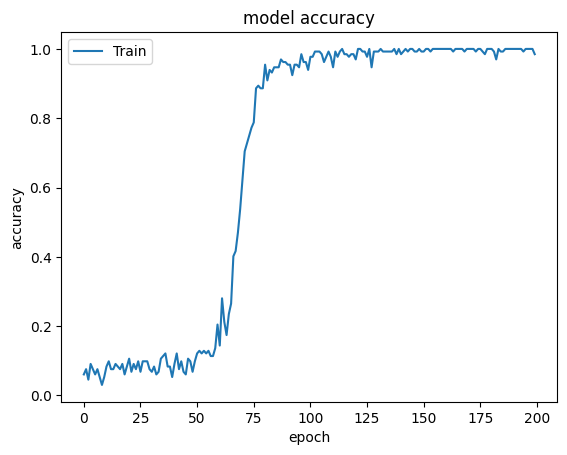

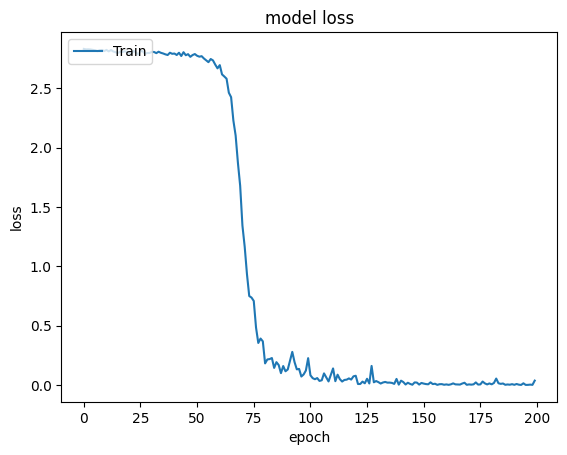

In [7]:
import json 
import random 
import pickle   
import numpy as np 

import nltk
from nltk.stem  import WordNetLemmatizer

from keras.models import Sequential , Model
from keras.layers import Dense,Input,Reshape ,Flatten,Conv2D,MaxPooling2D,Normalization,LeakyReLU,Dropout,Activation , Embedding,Conv1D,MaxPooling1D
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt

#########################-----Data------################################

intents = json.loads(open('data_train.json',errors='ignore').read())

words = [] # list các word có trong all pattern 
classes = [] # list các tag
documents = [] # list các words thuộc vào tag nào tương ứng
ignore_letter = ['?','.','!',','] # các ký tự cần loại bỏ

# thêm các từ theo từng tag vào document
for intent in intents['intents']:
    for patterns in intent['patterns']:
        word_list = nltk.word_tokenize(patterns) # tách từng từ trong patterns
        words.extend(word_list)
        documents.append((word_list, intent['tag'])) # để biết từ nào thuộc tag nào trong intent
        if intent['tag'] not in classes :
            classes.append(intent['tag']) # thêm tag vào doc


# đưa các từ về dạng nguyên thể để train cho bot (chỉ quan tâm đến nghĩa ,không quan tâm đế cú pháp)
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letter]

# xoá các từ trùng nhau (thu nhỏ size của data cần được train) và sắp xếp lại 
words = sorted(set(words))

# xếp classes
classes = sorted(set(classes))

# lưu  data word và classes vào các file để sử dụng cho file main.py
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

# hot encode pattern thành array có độ dài len(words) để làm input cho CNN
training = []
output_empty = [0] * len(classes) # list co gia tri =0

for document in documents :
    bag = [] # hot encode cua pattern là array có độ dài len(words)
    word_pattern = [lemmatizer.lemmatize(word.lower()) for word in document[0]]
    for word in words :
        bag.append(1) if word in word_pattern else bag.append(0) # nếu có từ nào trong words trùng với trong pattern thì :1 else 0

    # hot encode tag  thành 1 0 để thể hiện vị trí của tag trong classes
    output_lable = list(output_empty) # copy
    output_lable[classes.index(document[1])] = 1 # output 1 0 ( 1 : thể hiện vị trí của tag)
    # thêm vào traininng làm input 
    training.append([bag,output_lable])

# sắp xếp lại tranining randomly 
random.shuffle(training)
# chuyển về numpy array vì tensorflow làm việc với numpy
training = np.array(training)

# tách train_data và train_lable
train_x = list(training[:,0]) # lấy tất cả giá trị của cột đầu tiên 
train_y = list(training[:,1]) # ___________________________thứ hai


##############------BUILD MODEL --------###########

model = Sequential()

# embededing
MAX_SEQUENCE_LENGTH = len(train_x[0]) 
VOCAB_SIZE = len(words) 
EMBED_SIZE = 20

model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))

# bo CNN
# sử dụng bộ CONV1D vì đầu vào là mảng 1 chiều 
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))    
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# bo ANN  

model.add(Flatten()) # tao ra mot vetor phang
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]),activation='softmax'))
model.summary()


#############-----COMPILE------##################


sgd = SGD(lr=0.1,decay=1e-6,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=["accuracy"])
history= model.fit(np.array(train_x),np.array(train_y),batch_size=5 ,epochs=200,verbose=1)

# save model
model.save('chatboxfitness.h5',history)


# hien thi do thi 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
import json 
import random 
import pickle   
import numpy as np 

import nltk
from nltk.stem  import WordNetLemmatizer

from keras.models import Sequential , Model , load_model
from keras.layers import Dense,Input,Reshape ,Flatten,Conv2D,MaxPooling2D,Normalization,LeakyReLU,Dropout,Activation , Embedding
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt


intents = json.loads(open('data_test.json',errors='ignore').read())
words = [] # list các word có trong all pattern 
classes = [] # list các tag
documents = [] # list các words thuộc vào tag nào tương ứng
ignore_letter = ['?','.','!',','] # các ký tự cần loại bỏ

# thêm các từ theo từng tag vào document
for intent in intents['intents']:
    for patterns in intent['patterns']:
        word_list = nltk.word_tokenize(patterns) # tách từng từ trong patterns
        words.extend(word_list)
        documents.append((word_list, intent['tag'])) # để biết từ nào thuộc tag nào trong intent
        if intent['tag'] not in classes :
            classes.append(intent['tag']) # thêm tag vào doc


# đưa các từ về dạng nguyên thể để train cho bot (chỉ quan tâm đến nghĩa ,không quan tâm đế cú pháp)
lemmatizer = WordNetLemmatizer()

words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

# hot encode pattern thành array có độ dài len(words) để làm input cho CNN
test = []
output_empty = [0] * len(classes) # list co gia tri =0

for document in documents :
    bag = [] # hot encode cua pattern là array có độ dài len(words)
    word_pattern = [lemmatizer.lemmatize(word.lower()) for word in document[0]]
    for word in words :
        bag.append(1) if word in word_pattern else bag.append(0) # nếu có từ nào trong words trùng với trong pattern thì :1 else 0

    # hot encode tag  thành 1 0 để thể hiện vị trí của tag trong classes
    output_lable = list(output_empty) # copy
    output_lable[classes.index(document[1])] = 1 # output 1 0 ( 1 : thể hiện vị trí của tag)
    # thêm vào traininng làm input 
    test.append([bag,output_lable])

# sắp xếp lại tranining randomly 
random.shuffle(test)
# chuyển về numpy array vì tensorflow làm việc với numpy
test = np.array(test)

# tách train_data và train_lable
test_x = list(test[:,0]) # lấy tất cả giá trị của cột đầu tiên 
test_y = list(test[:,1]) # ___________________________thứ hai

# load model 
model = load_model('chatboxfitness.h5')

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(np.array(test_x), np.array(test_y), batch_size=5)
print("test loss, test acc:", results)

<ipython-input-8-277cc3a2d1e5>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(test)


Evaluate on test data
4/4 [==============================] - 0s 7ms/step - loss: 1.4482 - accuracy: 0.8889
test loss, test acc: [1.4481793642044067, 0.8888888955116272]


In [ ]:
import json 
import random 
import pickle   
import numpy as np 
import nltk
from nltk.stem  import WordNetLemmatizer
from keras.models import load_model
import time

import customtkinter 


############## Xử lý model #################

intents = json.loads(open('data_train.json',errors='ignore').read())
lemmatizer = WordNetLemmatizer()

# load data
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

# load model 
model = load_model('chatboxfitness.h5')

# chuyển từ về dạng nghĩa gốc
def clean_word(sentences):
    word_list = nltk.word_tokenize(sentences)
    word_list = [lemmatizer.lemmatize(word.lower()) for word in word_list]
    return word_list


# hot encode 
def bag_of_word (sentences):
    bag = []
    sentences=clean_word(sentences)
    for word in words :
        bag.append(1) if word in sentences else bag.append(0)    
    return np.array(bag)


# dự đoán kết quả
def predict_result(sentences):
    bag = bag_of_word(sentences)
    results = model.predict(np.array([bag]))[0]
    ERROR_THRESHOLD = 0.25
    # bỏ qua các kết quả có sai số thấp hơn 0.25
    result = [[index,res] for index , res in enumerate(results) if res > ERROR_THRESHOLD ]
    # sắp xếp theo thứ tự giảm dần 
    result.sort(key=lambda x: x[1] , reverse=True)
    
    # trả về các kết quả dự đoán được
    result_list = []
    for r in result :
        result_list.append({'intent':classes[r[0]] , 'probability' : r[1] })
    print(result_list)
    return result_list

# phản hồi 
def get_response(intent_list , intent_json):
    tag = intent_list[0]['intent'] # lấy giá trị có trọng số lớn nhất
    list_intent_json = intent_json['intents']
    for i in list_intent_json:
        if tag == i['tag']:
            result =random.choice(i['responses'])
            break
    # kiểm tra xác xuất : nếu <0.6 ==> không hiểu   
    pro = intent_list[0]['probability']
    if pro < 0.6 :
        result = "I'm sorry, I don't understand what you mean. Could you please clarify?"

    return result


############### GUI #####################

   

customtkinter.set_appearance_mode("dark")
customtkinter.set_default_color_theme("green")

root = customtkinter.CTk()
root.geometry("800x500")

# frame 
frame1 = customtkinter.CTkFrame(master = root )

frame2 = customtkinter.CTkFrame(master = root)

# function 
def select_frame(name):
    if name == "page1":
        frame1.pack(padx=10, pady=10,fill="both" ,expand = True)
    else :
        frame1.pack_forget()
    if name == "page2":
        frame2.pack(padx=10, pady=10,fill="both" ,expand = True)
    else :
        frame2.pack_forget()

def select_frame_1 ():
    select_frame("page1")

def select_frame_2 ():
    select_frame("page2")

def change_appearance_mode_event(new_appearance_mode: str):
    customtkinter.set_appearance_mode(new_appearance_mode)

def Quit():
    root.destroy()

# side bar frame 

option_mod = customtkinter.CTkFrame(master = root)
option_mod.pack(padx=10, pady=10, fill="both" ,expand = True ,side = 'left')

label_1_fm = customtkinter.CTkLabel(master = option_mod , text="Option" , font = ("Roboto",24))
label_1_fm.grid(row=0, column=0, padx=20, pady=(20, 10))

button_1_fm = customtkinter.CTkButton(master = option_mod ,text="Quit",command=Quit)
button_1_fm.grid(row=1, column=0, padx=20, pady=10)

option_fm = customtkinter.CTkOptionMenu(master = option_mod , values=["Dark","Light","System"],command=change_appearance_mode_event)
option_fm.grid(row=5, column=0, padx=20, pady=10)

# build frame 1 
label_1_f1 = customtkinter.CTkLabel(master = frame1 , text="Information" , font = ("Roboto",24))
label_1_f1.pack(pady = 12 , padx = 10)

entry_1_f1 = customtkinter.CTkEntry(master = frame1 , placeholder_text="Name" )
entry_1_f1.pack(pady = 12 , padx = 10)

entry_2_f1 = customtkinter.CTkEntry(master = frame1 , placeholder_text="Age" )
entry_2_f1.pack(pady = 12 , padx = 10)

entry_3_f1 = customtkinter.CTkEntry(master = frame1 , placeholder_text="Height")
entry_3_f1.pack(pady = 12 , padx = 10)

entry_4_f1 = customtkinter.CTkEntry(master = frame1 , placeholder_text="Weight")
entry_4_f1.pack(pady = 12 , padx = 10)

entry_5_f1 = customtkinter.CTkEntry(master = frame1 , placeholder_text="Female / Male")
entry_5_f1.pack(pady = 12 , padx = 10)

button_1_f1 = customtkinter.CTkButton(master=frame1 , text="Start", font=("Roboto",24),command=select_frame_2)
button_1_f1.pack(pady= 12 , padx = 10)



# build frame 2

textbox_1_f2 = customtkinter.CTkTextbox(master = frame2 , width=500 , height=400 ,corner_radius=10 ,font=("Roboto",15),wrap = 'word')
textbox_1_f2.grid(row=0 ,column=0 ,padx =40 , pady = 20)

entry_1_f2 = customtkinter.CTkEntry(master = frame2 ,placeholder_text="Type your questions here !!" , width=400 ,height=33,font=("Roboto",15))
entry_1_f2.grid(row=1, column=0 ,padx =40 , pady = 0,sticky = 'w')

def chat_message(event = None): 

    mess = entry_1_f2.get()
    textbox_1_f2.insert(customtkinter.END,"You :  " + mess+ '\n' +'\n')
    entry_1_f2.delete(0 , len(mess))
    # get result from model
    result_list = predict_result(mess)
    responses = get_response(result_list, intents)
    textbox_1_f2.tag_config("tagName",foreground='green')
    textbox_1_f2.insert(customtkinter.END, "ProTeenTeen :  " + responses + '\n' +'\n',"tagName")
    


button_1_f2 = customtkinter.CTkButton(master = frame2 ,text="Send" ,font=("Roboto",20) , command=chat_message ,width=35,height=20)
button_1_f2.place(x =465 , y = 440)

# keyboard enter to send messages
root.bind('<Return>',chat_message)

select_frame_1()

root.mainloop()



In [9]:
pip install customtkinter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 7.4 MB/s eta 0:00:00
